In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import conda_installer
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import matplotlib.pyplot as plt
from models.PGCN_model_multiloss import get_trained_model, test_model

2025-05-01 14:40:52.890246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-01 14:40:52.963328: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normaliz

In [2]:
X_folds= pickle.load(open('Datasets/X_folds_NMA_4.pkl', 'rb'))
y_folds = pickle.load(open('Datasets/y_folds_NMA_4.pkl', 'rb'))

In [4]:
K = 4
epoch = 2
hists = []
test_loss = []
predicts_train = []
predicts_test = []
y_diff = []

for k in range(K):
    X_train = []
    for i in range(K):
        if i != k:
            X_train += X_folds[i]
    X_test = X_folds[k]
    y_train = np.concatenate(np.array([y_folds[i] for i in range(K) if i != k]), 0)
    y_test = np.array(y_folds[k])
    #  Passing the X_train and x_add_train to train the model.
    hs, m, x_converted = get_trained_model(X_train, y_train, epochs = epoch, physics_weight = 0.005,max_num_atoms = 2000, n_features = 41)
    with open('Datasets/PGCN_vm2_ent_K%d_W_n.pkl' % k, 'wb') as f:
        pickle.dump([m.layers[0].w_n, m.layers[0].w_n], f)
        f.close()
    predicts_train.append(m.predict(x_converted, batch_size=len(X_train)))
    hists.append(hs)
    X_test[0].shape
    k_loss,y_difference, x_converted = test_model(X_test, y_test, m, max_num_atoms = 2000, n_features = 41)
    test_loss.append(k_loss)
    y_diff.append(y_difference)
    predicts_test.append(m.predict(x_converted, batch_size=len(X_test)))
    

Epoch 1/2
Inside call
Inside call
1/1 [==============================] - 44s 44s/step - loss: 1.6128
Epoch 2/2
1/1 [==============================] - 1s 647ms/step - loss: 2.2013
Inside call
1/1 [==============================] - 20s 20s/step
Inside call
1/1 [==============================] - 6s 6s/step
Inside call
1/1 [==============================] - 1s 955ms/step
Epoch 1/2
Inside call
Inside call
1/1 [==============================] - 52s 52s/step - loss: 1.4364
Epoch 2/2
1/1 [==============================] - 5s 5s/step - loss: 1.9317
Inside call
1/1 [==============================] - 17s 17s/step
Inside call
1/1 [==============================] - 6s 6s/step
Inside call
1/1 [==============================] - 0s 71ms/step
Epoch 1/2
Inside call
Inside call
1/1 [==============================] - 52s 52s/step - loss: 1.6473
Epoch 2/2
1/1 [==============================] - 7s 7s/step - loss: 2.1763
Inside call
1/1 [==============================] - 22s 22s/step
Inside call
1/1 [=======

In [5]:
# with open('PGCN_NMA_MultiLoss_K%d_fold_hists.pkl' % K, 'wb') as file:
#     pickle.dump(hists, file)
# with open('PGCN_NMA_MultiLoss_K%d_fold_test.pkl' % K, 'wb') as file:
#     pickle.dump(test_loss, file)
# with open('PGCN_NMA_MultiLoss_K%d_fold_train_pred.pkl' % K, 'wb') as file:
#     pickle.dump(predicts_train, file)
# with open('PGCN_NMA_MultiLoss_K%d_fold_test_pred.pkl' % K, 'wb') as file:
#     pickle.dump(predicts_test, file)

In [1]:
import pickle
import numpy as np
K = 4
PGCN_PG_hists = pickle.load(open('Datasets/PGCN_NMA_MultiLoss_K4_fold_hists.pkl', 'rb'))
PGCN_PG_loss = np.array(pickle.load(open('Datasets/PGCN_NMA_MultiLoss_K4_fold_test.pkl', 'rb')))
PGCN_PG_pred = pickle.load(open('Datasets/PGCN_NMA_MultiLoss_K4_fold_train_pred.pkl', 'rb'))


In [5]:
Test_loss = PGCN_PG_loss

In [10]:
train_loss = [PGCN_PG_hists[0][-1],PGCN_PG_hists[1][-1],PGCN_PG_hists[2][-1],PGCN_PG_hists[3][-1]]

In [11]:
train_loss

[1.5935277938842773, 1.3902627229690552, 1.626702904701233, 1.6456166505813599]

In [6]:
Test_loss

array([1.56434155, 2.07936954, 1.41159272, 1.33010435])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title("ΔG Comparison between Empirical and Structural Error")
plt.scatter(y_test, y_pred_test_struct, alpha=0.9,color="blue", label = "Structural Error")
plt.scatter(y_test, y_pred_test_nohyb, alpha=0.7,color="orange", label="PURE RMSE")
plt.scatter(y_test, hybrid_y_pred, alpha=0.6,color="purple", label="Multi-Loss")

plt.xlabel("Experimental ΔG (y_true)")
plt.ylabel("Predicted ΔG (y_pred)")
plt.xlim(-1,12)
plt.ylim(-1, 12)

# Reference y = x line
plt.plot([-1, 12], [-1, 12], color='green', lw=1, linestyle='--')

plt.legend()
plt.tight_layout()

plt.savefig('Emp_Struct_Phy_Loss.png.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
PGCN_PG_loss

array([1.56434155, 2.07936954, 1.41159272, 1.33010435])

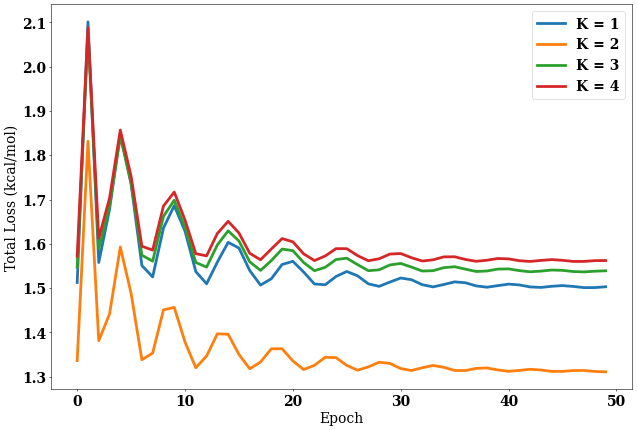

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)
figure(figsize=(15, 10), dpi=50)
for i in range(K):
    plt.plot(np.array(PGCN_PG_hists[i][0:50]) - .1, label='K = %d' % (i + 1), linewidth=4)
plt.xlabel('Epoch')
plt.ylabel('Total Loss (kcal/mol)')

plt.legend()
plt.savefig('Graphs/PGCN_NMA_Multiloss_K_fold.png')

In [9]:
%cd ..

/home/lthoma21/BFE-Loss-Function


In [16]:
X_fold_test= pickle.load(open('X_folds_test_LT_4.pkl', 'rb'))
y_fold_test = pickle.load(open('y_folds_test_LT_4.pkl', 'rb'))
k_loss, x_converted = test_model(X_fold_test, y_fold_test, m)

# check size after this

1/1 [==============================] - 2s 2s/step - loss: 26.6978


In [12]:
# X_test.shape
# y_fold_test[0]


# y_fold_test = np.array(y_fold_test)

2.74

In [21]:
# # input_shapes_brd4 = []
# # print("X_test shape before evaluate:", X_fold_test[0].shape)
# # for i in range(len(X_fold_test)):
# #     input_shapes_brd4.append(np.array(X_fold_test[i]).shape[0])
# # m.set_input_shapes(input_shapes_brd4)
# # print(m.i_s)
# # for i in range(len(X_fold_test)):
# #     if X_fold_test[i].shape[0] < 2000:
# #         new_list = np.zeros([2000 - X_fold_test[i].shape[0], 41])
# #         X_fold_test[i] = np.concatenate([X_fold_test[i], new_list], 0)   
# # print("X_test shape after evaluate:", X_fold_test[0].shape)
# # predicts_train.append(m.predict(x_converted, batch_size=len(X_fold_test)))


# input_shapes = []
# y_test = y_folds[int(.8*len(X_folds)):]
# for i in range(len(X_test)):
#     input_shapes.append(np.array(X_test[i]).shape[0])
# m.set_input_shapes(input_shapes)
# for i in range(len(X_test)):
#     if X_test[i].shape[0] < 2000:
#         new_list = np.zeros([2000 - X_test[i].shape[0], 41])
#         X_test[i] = np.concatenate([X_test[i], new_list], 0)
# X_test = np.array(X_test)
# y_test = np.array(y_test)
# m.evaluate(X_test, y_test)


In [22]:
# input_shapes = []


# m.set_input_shapes(input_shapes)
# for i in range(len(X_fold_test)):
#     if X_fold_test[i].shape[0] < 2000:
#         new_list = np.zeros([2000 - X_fold_test[i].shape[0], 41])
#         X_fold_test[i] = np.concatenate([X_fold_test[i], new_list], 0)

# X_fold_test = np.array(X_fold_test)
# y_fold_test = np.array(y_fold_test)
# m.evaluate(X_fold_test, y_fold_test)

In [30]:
# k_loss, x_converted = test_model(X_test, y_test, m)

# predicts_test.append(m.predict(x_converted, batch_size=len(X_test)))

1/1 [==============================] - 0s 172ms/step


In [80]:
# X_test[0].shape

(2000, 41)